## BAŞVURU PUANI TAHMİNİ

İş Problemi: Başvuru puanını tahmin ederek başvuru puanının ne olacağını belirlemek.   
Hedef: Özelliklere dayalı olarak puan tahmin etmek için regresyon modelleri geliştirmek.


In [300]:
# Eğer yüklü değilse gerekli kütüphanelerin yüklenmesi
# pip install pandas scikit-learn matplotlib seaborn

In [301]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from scipy.stats import pearsonr
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest, f_regression

print("Kurulumlar başarılı!")

Kurulumlar başarılı!


VERİ ÖN İŞLEME

In [302]:
# Excel dosyasını okuma
file_name = 'BASVURU.xlsx'
# DataFrame'i daha şık görüntüleme
dff = pd.read_excel(file_name, engine='openpyxl') 
# Tablo görüntüleme
dff.head()  


,KISI_ID,BASVURU_ID,YIL,DÖNEM,BASVURU_TIPI,UYRUK,CINSIYET,PUAN,BASARI_DURUMU,KESIN_KAYIT_DURUMU
0,NaN,9,2012,Güz,Uluslararası Öğrenci,İRAN,Kadın,15.0,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI
1,NaN,12,2012,Güz,Uluslararası Öğrenci,TÜRKMENİSTAN,Kadın,5.0,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI
2,NaN,16,2012,Güz,Uluslararası Öğrenci,AZERBAYCAN,Erkek,1430.0,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI
3,NaN,20,2012,Güz,Uluslararası Öğrenci,SURİYE,Erkek,220.0,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI
4,NaN,26,2012,Güz,Uluslararası Öğrenci,TÜRKMENİSTAN,Kadın,76.0,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI


In [303]:
# Veri setinin boyutlarını öğrenme
print(dff.shape)

(17548, 10)


In [304]:
# Sütun adlarını ve veri tiplerini görüntüleme
print(dff.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17548 entries, 0 to 17547
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   KISI_ID             1026 non-null   float64
 1   BASVURU_ID          17548 non-null  int64  
 2   YIL                 17548 non-null  int64  
 3   DÖNEM               17548 non-null  object 
 4   BASVURU_TIPI        17548 non-null  object 
 5   UYRUK               17548 non-null  object 
 6   CINSIYET            17548 non-null  object 
 7   PUAN                17548 non-null  float64
 8   BASARI_DURUMU       17548 non-null  object 
 9   KESIN_KAYIT_DURUMU  17548 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 1.3+ MB
None


In [305]:
# Veri setinin ilk istatistiksel özetini alma
print(dff.describe())

            KISI_ID    BASVURU_ID           YIL          PUAN
count  1.026000e+03  17548.000000  17548.000000  17548.000000
mean   8.479358e+05   6126.239913   2013.821860    114.259668
std    3.680203e+05   3208.415247      0.635975    259.577873
min    3.300000e+01      5.000000   2010.000000      0.000000
25%    1.007124e+06   3857.000000   2014.000000     45.500000
50%    1.007330e+06   6019.500000   2014.000000     67.165000
75%    1.007775e+06   8918.250000   2014.000000     81.250000
max    1.009997e+06  12326.000000   2015.000000   7168.000000


In [306]:
# Hatalı sonuç alamamak adına 'KISI_ID', 'BASVURU_ID' ve 'YIL' sütunlarını kategorik veriye çevirme ve görüntüleme
dff['KISI_ID'] = dff['KISI_ID'].astype('object')
dff['BASVURU_ID'] = dff['BASVURU_ID'].astype('object')
dff['YIL'] = dff['YIL'].astype('object')
print(dff.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17548 entries, 0 to 17547
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   KISI_ID             1026 non-null   object 
 1   BASVURU_ID          17548 non-null  object 
 2   YIL                 17548 non-null  object 
 3   DÖNEM               17548 non-null  object 
 4   BASVURU_TIPI        17548 non-null  object 
 5   UYRUK               17548 non-null  object 
 6   CINSIYET            17548 non-null  object 
 7   PUAN                17548 non-null  float64
 8   BASARI_DURUMU       17548 non-null  object 
 9   KESIN_KAYIT_DURUMU  17548 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.3+ MB
None


In [307]:
# Veri setinin istatistiksel özetini alma
print(dff.describe())

               PUAN
count  17548.000000
mean     114.259668
std      259.577873
min        0.000000
25%       45.500000
50%       67.165000
75%       81.250000
max     7168.000000


In [308]:
# Eksik verileri kontrol etme
print(dff.isnull().sum())

KISI_ID               16522
BASVURU_ID                0
YIL                       0
DÖNEM                     0
BASVURU_TIPI              0
UYRUK                     0
CINSIYET                  0
PUAN                      0
BASARI_DURUMU             0
KESIN_KAYIT_DURUMU        0
dtype: int64


In [309]:
# Eksik verileri belirli sütunlar için kontrol etme
for col in dff.columns:
    missing_count = dff[col].isnull().sum()
    if missing_count > 0:
        print(f"{col} sütununda {missing_count} eksik veri var.")

KISI_ID sütununda 16522 eksik veri var.


In [310]:
# KISI_ID sütununu atma
dff = dff.drop(columns=['KISI_ID'])

# Güncellenmiş veri setinin kaydedilmesi ve görüntülenmesi
dff.to_csv('cleaned_data_without_id.csv', index=False)
dff.head()

,BASVURU_ID,YIL,DÖNEM,BASVURU_TIPI,UYRUK,CINSIYET,PUAN,BASARI_DURUMU,KESIN_KAYIT_DURUMU
0,9,2012,Güz,Uluslararası Öğrenci,İRAN,Kadın,15.0,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI
1,12,2012,Güz,Uluslararası Öğrenci,TÜRKMENİSTAN,Kadın,5.0,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI
2,16,2012,Güz,Uluslararası Öğrenci,AZERBAYCAN,Erkek,1430.0,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI
3,20,2012,Güz,Uluslararası Öğrenci,SURİYE,Erkek,220.0,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI
4,26,2012,Güz,Uluslararası Öğrenci,TÜRKMENİSTAN,Kadın,76.0,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI


In [311]:
# Sütun adlarını görüntüleme
print("Orijinal Sütunlar:", dff.columns)

Orijinal Sütunlar: Index(['BASVURU_ID', 'YIL', 'DÖNEM', 'BASVURU_TIPI', 'UYRUK', 'CINSIYET',
       'PUAN', 'BASARI_DURUMU', 'KESIN_KAYIT_DURUMU'],
      dtype='object')


In [312]:
# Veri setindeki kategorik ve sayısal değişkenleri ayırma
categorical_cols = dff.select_dtypes(include=['object']).columns
numerical_cols = dff.select_dtypes(include=['number']).columns

print(f"Kategorik Sütunlar: {categorical_cols}")
print(f"Sayısal Sütunlar: {numerical_cols}")

Kategorik Sütunlar: Index(['BASVURU_ID', 'YIL', 'DÖNEM', 'BASVURU_TIPI', 'UYRUK', 'CINSIYET',
       'BASARI_DURUMU', 'KESIN_KAYIT_DURUMU'],
      dtype='object')
Sayısal Sütunlar: Index(['PUAN'], dtype='object')


In [313]:
# Kategorik sütunlar ve benzersiz değerlerin sayısını hesaplama
unique_counts = {
    'Başvuru ID': len(dff['BASVURU_ID'].unique()),
    'Yıl': len(dff['YIL'].unique()),
    'Dönem': len(dff['DÖNEM'].unique()),
    'Başvuru Tipi': len(dff['BASVURU_TIPI'].unique()),
    'Uyruk': len(dff['UYRUK'].unique()),
    'Cinsiyet': len(dff['CINSIYET'].unique()),
    'Başarı Durumu': len(dff['BASARI_DURUMU'].unique()),
    'Kesin Kayıt Durumu': len(dff['KESIN_KAYIT_DURUMU'].unique())
}

# Sonuçları yazdırma
print("Kategorik Sütunların Benzersiz Değer Sayıları:")
for column, count in unique_counts.items():
    print(f"{column}: {count} benzersiz değer")

Kategorik Sütunların Benzersiz Değer Sayıları:
Başvuru ID: 9786 benzersiz değer
Yıl: 5 benzersiz değer
Dönem: 2 benzersiz değer
Başvuru Tipi: 3 benzersiz değer
Uyruk: 79 benzersiz değer
Cinsiyet: 3 benzersiz değer
Başarı Durumu: 7 benzersiz değer
Kesin Kayıt Durumu: 2 benzersiz değer


In [314]:
# Çok fazla benzersiz değer içerdiğinden BASVURU_ID sütununu atma
dff = dff.drop(columns=['BASVURU_ID'])

# Güncellenmiş veri setinin kaydedilmesi ve görüntülenmesi
dff.to_csv('cleaned_data_without_id.csv', index=False)
dff.head()

,YIL,DÖNEM,BASVURU_TIPI,UYRUK,CINSIYET,PUAN,BASARI_DURUMU,KESIN_KAYIT_DURUMU
0,2012,Güz,Uluslararası Öğrenci,İRAN,Kadın,15.0,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI
1,2012,Güz,Uluslararası Öğrenci,TÜRKMENİSTAN,Kadın,5.0,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI
2,2012,Güz,Uluslararası Öğrenci,AZERBAYCAN,Erkek,1430.0,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI
3,2012,Güz,Uluslararası Öğrenci,SURİYE,Erkek,220.0,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI
4,2012,Güz,Uluslararası Öğrenci,TÜRKMENİSTAN,Kadın,76.0,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI


In [315]:
# Hata kontrolü için kategorik veri içeren sütunların benzersiz değerlerinin görüntülenmesi
# Benzersiz değerlerin listesi
unique_values_yil = map(str, dff['YIL'].unique())
unique_values_donem = dff['DÖNEM'].unique()
unique_values_tip = dff['BASVURU_TIPI'].unique()
unique_values_uyruk = dff['UYRUK'].unique()
unique_values_cinsiyet = dff['CINSIYET'].unique()
unique_values_basari = dff['BASARI_DURUMU'].unique()
unique_values_kayit = dff['KESIN_KAYIT_DURUMU'].unique()

# Tabloyu oluşturma
output = f"""
Benzersiz Değerler Tablosu:

Yıl:
{', '.join(unique_values_yil)}

Dönem:
{', '.join(unique_values_donem)}

Başvuru Tipi:
{', '.join(unique_values_tip)}

Uyruk:
{textwrap.fill(', '.join(unique_values_uyruk), width=180)}

Cinsiyet:
{', '.join(unique_values_cinsiyet)}

Başarı Durumu:
{textwrap.fill(', '.join(unique_values_basari))}

Kesin Kayıt Durumu:
{', '.join(unique_values_kayit)}
"""

print(output)



Benzersiz Değerler Tablosu:

Yıl:
2012, 2013, 2014, 2015, 2010

Dönem:
Güz, Bahar

Başvuru Tipi:
Uluslararası Öğrenci, Enstitu, Lisans Yatay Geçiş

Uyruk:
İRAN, TÜRKMENİSTAN, AZERBAYCAN, SURİYE, FİLİSTİN, YUNANİSTAN, İNGİLTERE / BİRLEŞİK KRALLIK, ALMANYA, UKRAYNA, TACİKİSTAN, ARNAVUTLUK, ÖZBEKİSTAN, TÜRKİYE, MORİTANYA, A.B.D., KUZEY
MAKEDONYA, KUZEY KIBRIS TÜRK CUMHURİYETİ, IRAK, KIRGIZİSTAN, AFGANİSTAN, AVUSTURYA, KENYA, KOSOVA, MISIR, BULGARİSTAN, TANZANYA, GÜRCİSTAN, SIRBİSTAN, FRANSA, ÇİN, GÜNEY AFRİKA,
PAKİSTAN, RUSYA, ÜRDÜN, ROMANYA, HOLLANDA, SOMALİ, ENDONEZYA, SUDAN, DANİMARKA, GİNE BİSSAU, FAS, İSRAİL, UGANDA, SUUDİ ARABİSTAN, ÇAD, YEMEN, NİJERYA, SENEGAL, KAMERUN, LİBYA,
İTALYA, TUNUS, MALİ, GİNE, KAZAKİSTAN, İSVİÇRE, PERU, MOLDOVA, GÜNEY KIBRIS RUM KESİMİ, BOSNA HERSEK, KANADA, ETİOPYA, KARADAĞ, AMERİKAN SAMOA, MOĞOLİSTAN, AVUSTRALYA, BELÇİKA,
GANA, İSVEÇ, FİLİPİNLER, PAPUA YENİ GİNE, LÜBNAN, ANGOLA, NEPAL, ZAMBİA, BURMA, MAURİTUS, JAPONYA

Cinsiyet:
Kadın, Erkek, Bilinmeye

In [316]:
# Cinsiyet sütununu yakından inceleme
value_counts_cinsiyet = dff['CINSIYET'].value_counts()
print("Cinsiyet Değerlerinin Sayımları:")
print(value_counts_cinsiyet)

Cinsiyet Değerlerinin Sayımları:
CINSIYET
Erkek         10755
Kadın          6769
Bilinmeyen       24
Name: count, dtype: int64


In [317]:
# Bilinmeyen cinsiyet değerlerine sahip satırları filtreleme
df = dff[dff['CINSIYET'] != 'Bilinmeyen']

# Filtrelenmiş veri setini kontrol etme
print(df['CINSIYET'].value_counts())


CINSIYET
Erkek    10755
Kadın     6769
Name: count, dtype: int64


In [318]:
# Güncellenmiş veri setini kaydetme ve görüntüleme
df.to_csv('corrected_data.csv', index=False)
df

,YIL,DÖNEM,BASVURU_TIPI,UYRUK,CINSIYET,PUAN,BASARI_DURUMU,KESIN_KAYIT_DURUMU
0,2012,Güz,Uluslararası Öğrenci,İRAN,Kadın,15.00,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI
1,2012,Güz,Uluslararası Öğrenci,TÜRKMENİSTAN,Kadın,5.00,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI
2,2012,Güz,Uluslararası Öğrenci,AZERBAYCAN,Erkek,1430.00,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI
3,2012,Güz,Uluslararası Öğrenci,SURİYE,Erkek,220.00,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI
4,2012,Güz,Uluslararası Öğrenci,TÜRKMENİSTAN,Kadın,76.00,DEGERLENDIRILMEDI,KESIN KAYIT YAPMADI
...,...,...,...,...,...,...,...,...
17543,2015,Güz,Enstitu,TÜRKİYE,Kadın,75.44,Kazandı,KESIN KAYIT YAPTI
17544,2015,Güz,Enstitu,TÜRKİYE,Kadın,76.50,Kazandı,KESIN KAYIT YAPTI
17545,2015,Güz,Enstitu,TÜRKİYE,Kadın,76.90,Kazandı,KESIN KAYIT YAPTI
17546,2015,Güz,Enstitu,TÜRKİYE,Erkek,77.77,Kazandı,KESIN KAYIT YAPTI


In [319]:
# Veri setinin boyutlarını öğrenme
print(df.shape)

(17524, 8)


In [320]:
# Kategorik veri türlerinin sayısal veriye dönüştürülmesi (Kategorik verilerin encodingi)
# Kategorik sütunların seçilmesi
categorical_features = ['YIL', 'DÖNEM', 'BASVURU_TIPI', 'UYRUK', 'CINSIYET', 'BASARI_DURUMU', 'KESIN_KAYIT_DURUMU']

# One-Hot Encoding uygulanması
encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' ilk kategoriyi kaldırarak dummy variable trap'ı önler, sparse_output=True, varsayılan olarak sparse matrix döndürür
encoded_features = encoder.fit_transform(dff[categorical_features])

# DataFrame'e dönüştürülmesi
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Orijinal ve encode edilmiş verilerin birleştirilmesi
df_encoded = pd.concat([dff.drop(columns=categorical_features), encoded_df], axis=1)


In [321]:
# Birleşmiş verinin görüntülenmesi
df_encoded

,PUAN,YIL_2012,YIL_2013,YIL_2014,YIL_2015,DÖNEM_Güz,BASVURU_TIPI_Lisans Yatay Geçiş,BASVURU_TIPI_Uluslararası Öğrenci,UYRUK_AFGANİSTAN,UYRUK_ALMANYA,...,UYRUK_İTALYA,CINSIYET_Erkek,CINSIYET_Kadın,BASARI_DURUMU_DEGERLENDIRILMEDI,BASARI_DURUMU_Kazanamadı,BASARI_DURUMU_Kazanamadı (Başarı Notu Yetersiz),BASARI_DURUMU_Kazanamadı (Mülakat Notu Yetersiz),BASARI_DURUMU_Kazandı,BASARI_DURUMU_Yedek,KESIN_KAYIT_DURUMU_KESIN KAYIT YAPTI
0,15.00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1430.00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,220.00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,76.00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17543,75.44,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
17544,76.50,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
17545,76.90,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
17546,77.77,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [322]:
print(encoded_df.dtypes)

YIL_2012                                            float64
YIL_2013                                            float64
YIL_2014                                            float64
YIL_2015                                            float64
DÖNEM_Güz                                           float64
                                                     ...   
BASARI_DURUMU_Kazanamadı (Başarı Notu Yetersiz)     float64
BASARI_DURUMU_Kazanamadı (Mülakat Notu Yetersiz)    float64
BASARI_DURUMU_Kazandı                               float64
BASARI_DURUMU_Yedek                                 float64
KESIN_KAYIT_DURUMU_KESIN KAYIT YAPTI                float64
Length: 94, dtype: object


In [323]:
# Yıllara göre ortalama PUAN hesaplama
average_score_per_year = dff.groupby('YIL')['PUAN'].mean().reset_index()

print("Yıllara Göre Ortalama Puanlar:")
print(average_score_per_year)

Yıllara Göre Ortalama Puanlar:
    YIL        PUAN
0  2010   54.500000
1  2012   97.378254
2  2013  133.612759
3  2014  117.164251
4  2015   58.456567


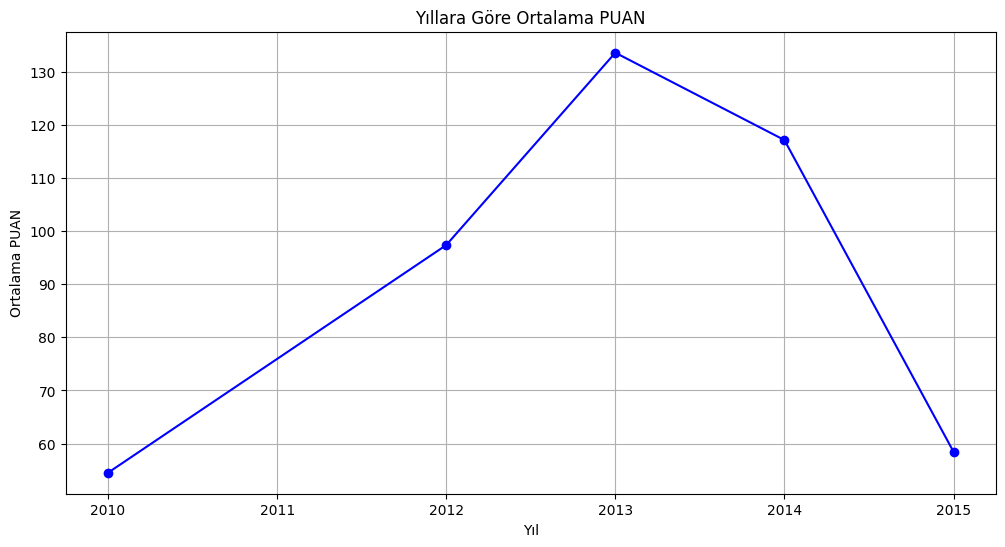

In [324]:
# Yıllara göre ortalama PUAN görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(average_score_per_year['YIL'], average_score_per_year['PUAN'], marker='o', linestyle='-', color='b')
plt.xlabel('Yıl')
plt.ylabel('Ortalama PUAN')
plt.title('Yıllara Göre Ortalama PUAN')
plt.grid(True)
plt.show()

In [325]:
# Dönemlere göre ortalama PUAN hesaplama
average_score_per_term = dff.groupby('DÖNEM')['PUAN'].mean().reset_index()

print("Dönemlere Göre Ortalama Puanlar:")
print(average_score_per_term)

Dönemlere Göre Ortalama Puanlar:
   DÖNEM        PUAN
0  Bahar  137.426328
1    Güz  108.336628


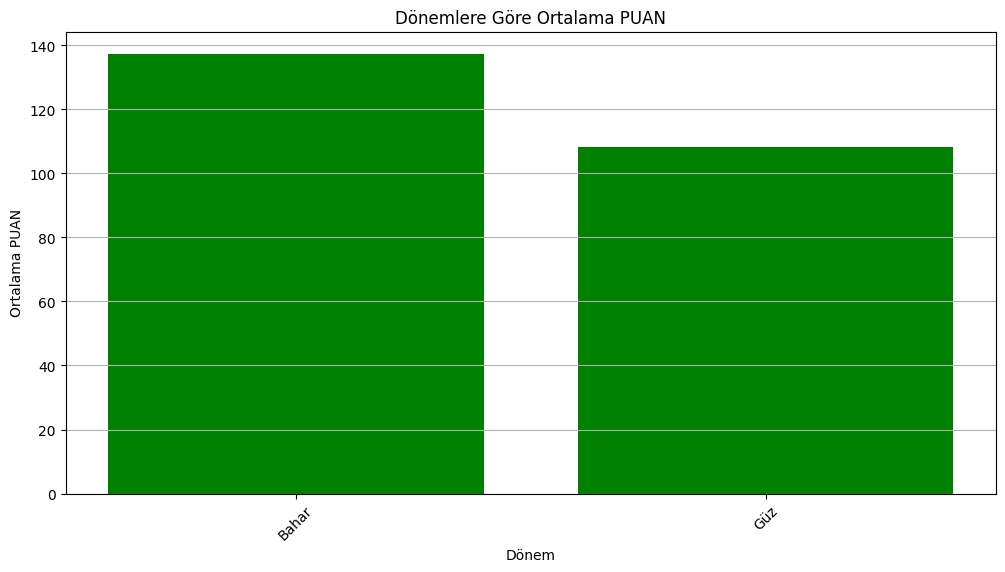

In [326]:
# Dönemlere göre ortalama PUAN görselleştirme
plt.figure(figsize=(12, 6))
plt.bar(average_score_per_term['DÖNEM'], average_score_per_term['PUAN'], color='g')
plt.xlabel('Dönem')
plt.ylabel('Ortalama PUAN')
plt.title('Dönemlere Göre Ortalama PUAN')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

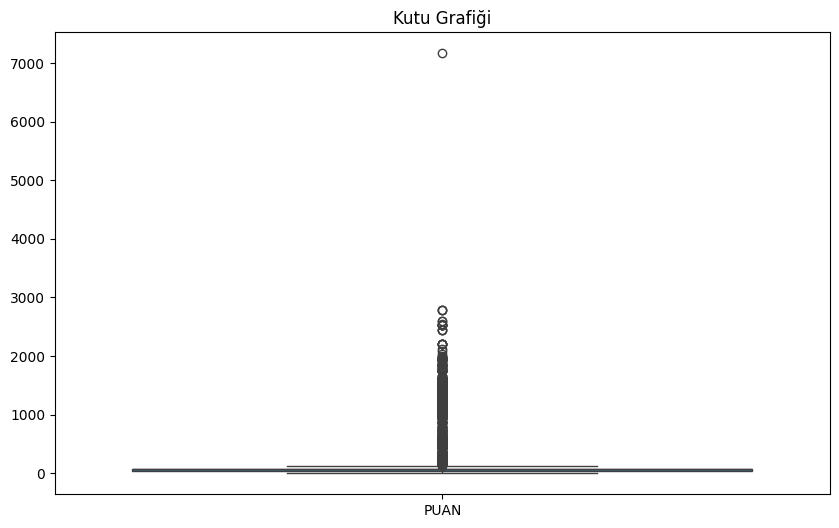

In [327]:
# Kutu grafiği oluşturma
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_encoded[['PUAN']])
plt.title('Kutu Grafiği')
plt.show()


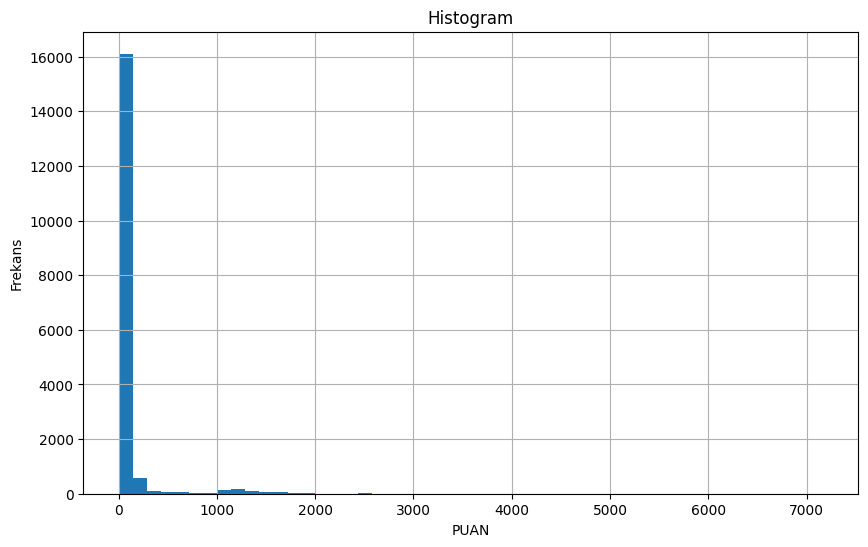

In [328]:
# Histogram oluşturma
plt.figure(figsize=(10, 6))
df_encoded['PUAN'].hist(bins=50)
plt.title('Histogram')
plt.xlabel('PUAN')
plt.ylabel('Frekans')
plt.show()

In [329]:
# Korelasyon matrisini oluşturma
correlation_matrix = df_encoded.corr()

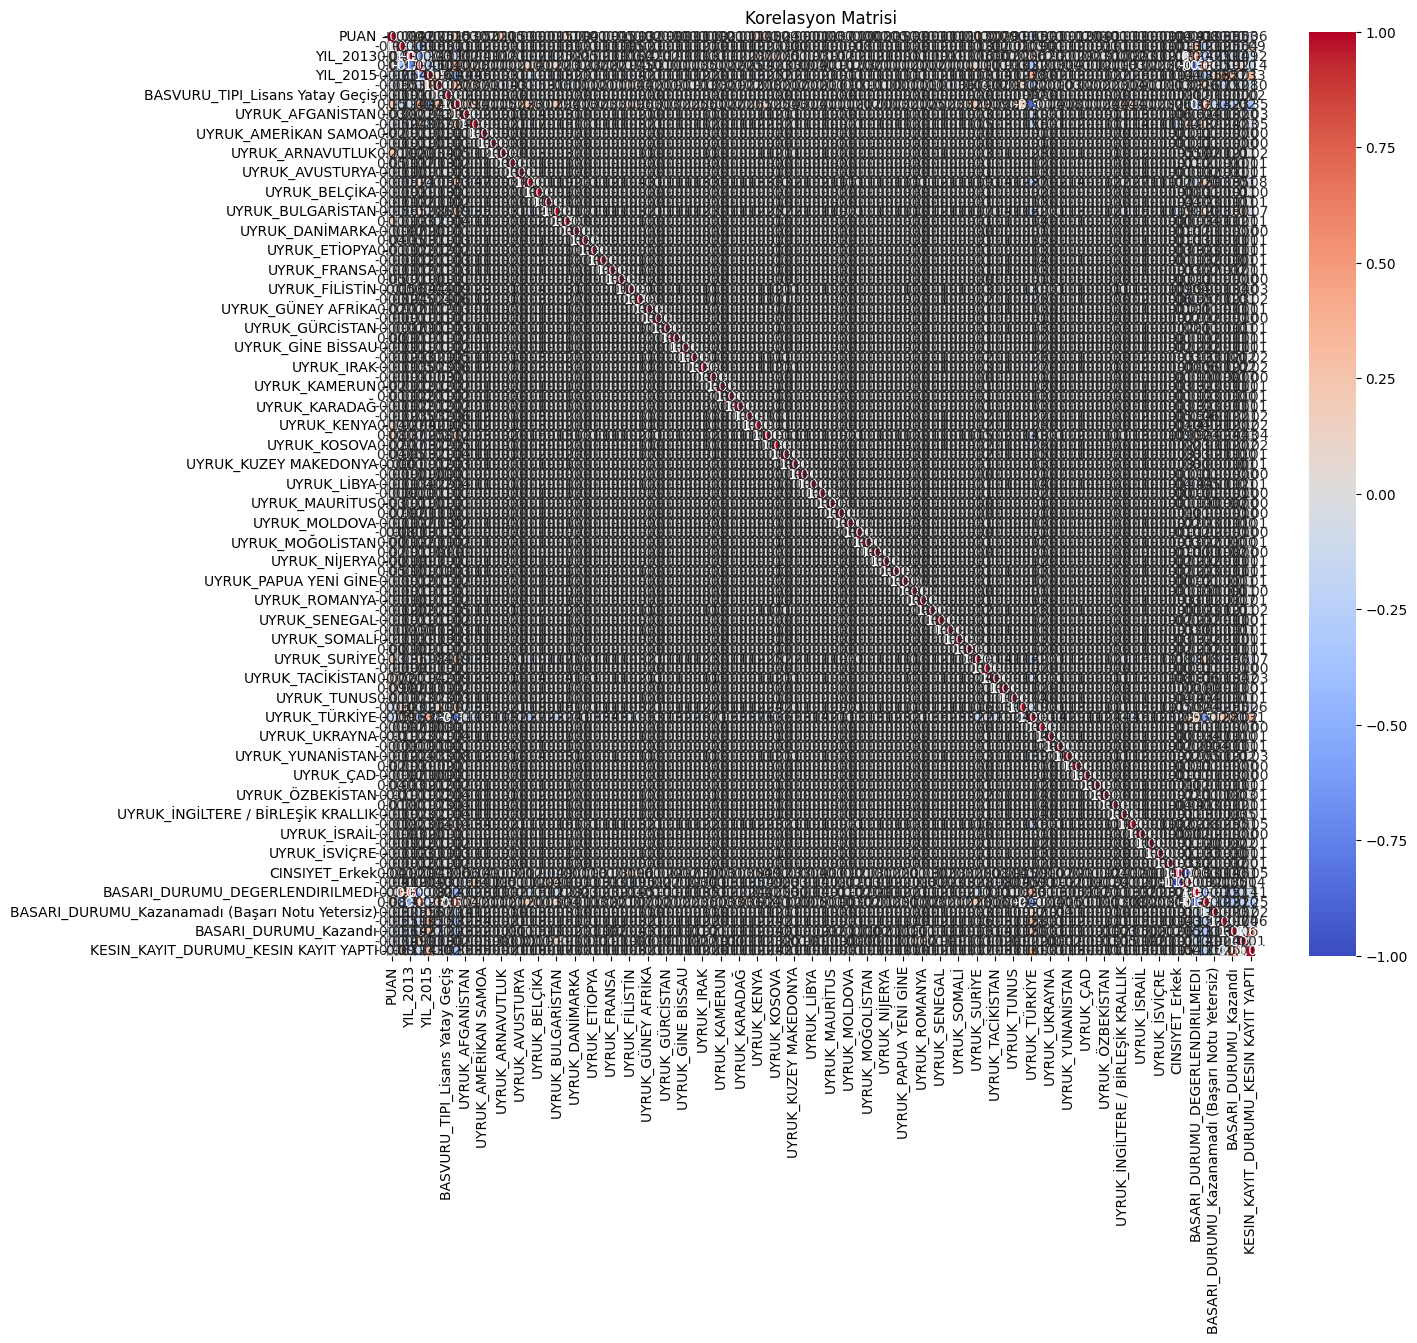

In [330]:
# Korelasyon matrisini görselleştirme
plt.figure(figsize=(14, 12))  
heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,  # Hücrelerdeki değerleri gösterir
    cmap='coolwarm',  # Renk şeması
    fmt='.2f',  # Değerlerin biçimi
    vmin=-1, vmax=1,  # Renk skalası sınırları
    linewidths=0.5,  # Hücreler arasındaki çizgi kalınlığı
    linecolor='gray'  # Hücreler arasındaki çizgi rengi
)
plt.title('Korelasyon Matrisi')
plt.show()

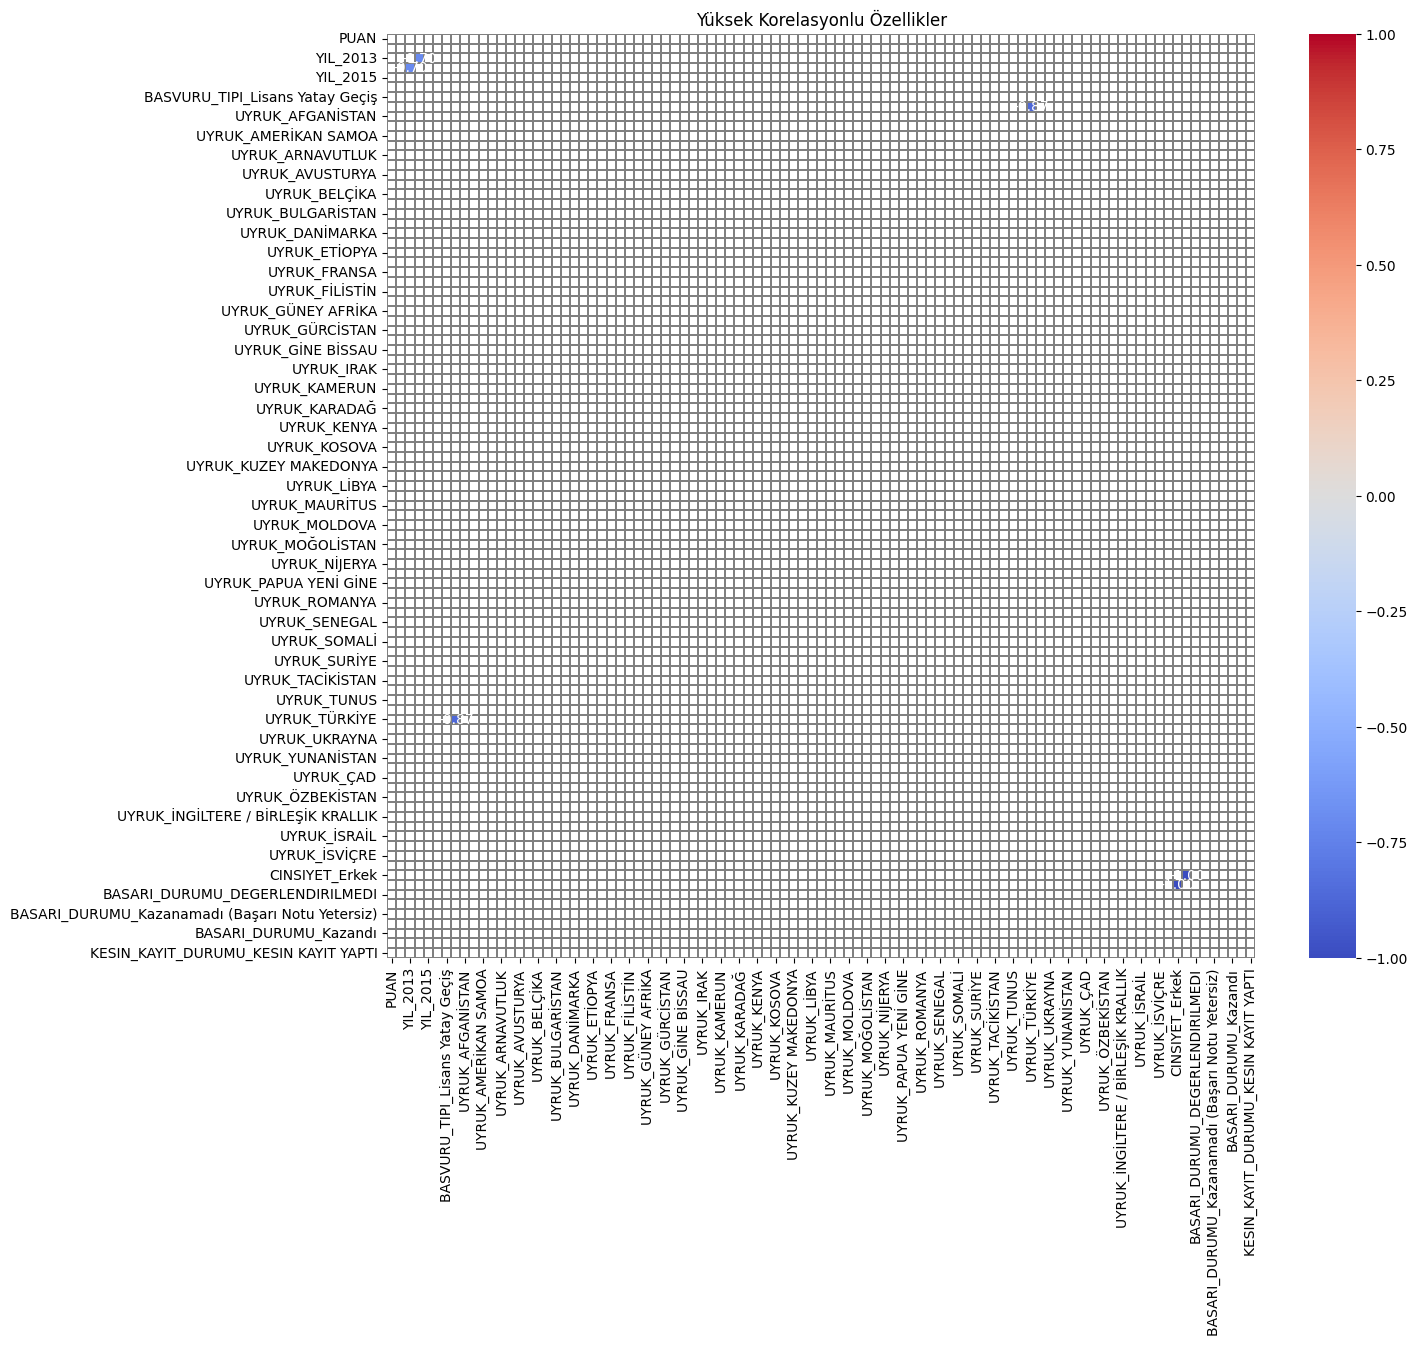

In [331]:
# Korelasyon matrisini filtreleme
threshold = 0.7
high_corr = correlation_matrix[(np.abs(correlation_matrix) >= threshold) & (np.abs(correlation_matrix) < 1.0)]

# Filtrelenmiş korelasyon matrisini görselleştirme
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(
    high_corr,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    vmin=-1, vmax=1,
    linewidths=0.2,
    linecolor='gray'
)
plt.title('Yüksek Korelasyonlu Özellikler')
plt.show()


In [332]:
# NaN ve boş değerleri temizleme
high_corr = high_corr.dropna(how='all').dropna(axis=1, how='all')

# Filtrelenmiş korelasyonları yazdırma
print("Korelasyon Değerleri 0.7 ve Üzeri veya -0.7 ve Altı:")
for i in range(len(high_corr.columns)):
    for j in range(i):
        if abs(high_corr.iloc[i, j]) >= 0.7:
            print(f"{high_corr.columns[i]} ile {high_corr.columns[j]}: {high_corr.iloc[i, j]:.2f}")


Korelasyon Değerleri 0.7 ve Üzeri veya -0.7 ve Altı:
YIL_2014 ile YIL_2013: -0.70
UYRUK_TÜRKİYE ile BASVURU_TIPI_Uluslararası Öğrenci: -0.87
CINSIYET_Kadın ile CINSIYET_Erkek: -1.00


In [333]:
# Korelasyon matrisini hesaplama
corr_matrix = df_encoded.corr()

In [334]:
# PUAN sütunu ile olan korelasyonları bulma
correlation_with_target = corr_matrix['PUAN'].abs().sort_values(ascending=False)

# En yüksek korelasyona sahip sütunları görüntüleme
top_correlated_features = correlation_with_target.head(50)
print(top_correlated_features)


PUAN                                                1.000000
UYRUK_ARNAVUTLUK                                    0.209815
BASVURU_TIPI_Uluslararası Öğrenci                   0.150087
UYRUK_TÜRKİYE                                       0.146735
UYRUK_KENYA                                         0.140154
UYRUK_SURİYE                                        0.132283
UYRUK_BURMA                                         0.107216
UYRUK_TANZANYA                                      0.092755
UYRUK_KIRGIZİSTAN                                   0.083753
BASARI_DURUMU_Kazanamadı                            0.081295
UYRUK_TACİKİSTAN                                    0.073974
UYRUK_MISIR                                         0.069747
YIL_2015                                            0.066013
UYRUK_TÜRKMENİSTAN                                  0.064987
KESIN_KAYIT_DURUMU_KESIN KAYIT YAPTI                0.057135
UYRUK_PAKİSTAN                                      0.051428
BASARI_DURUMU_Kazandı   

In [335]:
# Korelasyon ve p-değeri hesaplama fonksiyonu
def get_correlation_p_value(x, y):
    corr, p_value = pearsonr(x, y)
    return corr, p_value

# Korelasyon ve p-değerlerini saklamak için boş listeler
correlations = []
p_values = []

# Özellikler arasında döngü
for column in df_encoded.columns:
    if column != 'PUAN':
        corr, p_value = get_correlation_p_value(df_encoded['PUAN'], df_encoded[column])
        correlations.append((column, corr))
        p_values.append((column, p_value))

# Korelasyonları DataFrame'e dönüştürme ve sıralama
corr_df = pd.DataFrame(correlations, columns=['Feature', 'Correlation'])
corr_df = corr_df.sort_values(by='Correlation', ascending=False)

# p-değerlerini DataFrame'e dönüştürme ve sıralama
p_value_df = pd.DataFrame(p_values, columns=['Feature', 'P_Value'])
p_value_df = p_value_df.sort_values(by='P_Value')

# En yüksek pozitif ve negatif korelasyonlara sahip 10 sütun
top_positive_negative_corr = pd.concat([corr_df.head(5), corr_df.tail(5)])

# En düşük p-değerine sahip 10 sütun
top_low_p_values = p_value_df.head(10)

# Sonuçları yazdırma
print("En Yüksek Pozitif ve Negatif Korelasyonlara Sahip 10 Sütun:")
print(top_positive_negative_corr)

print("\nEn Düşük P-Değerine Sahip 10 Sütun:")
print(top_low_p_values)


En Yüksek Pozitif ve Negatif Korelasyonlara Sahip 10 Sütun:
                                 Feature  Correlation
11                      UYRUK_ARNAVUTLUK     0.209815
6      BASVURU_TIPI_Uluslararası Öğrenci     0.150087
39                           UYRUK_KENYA     0.140154
63                          UYRUK_SURİYE     0.132283
18                           UYRUK_BURMA     0.107216
91                 BASARI_DURUMU_Kazandı    -0.050450
93  KESIN_KAYIT_DURUMU_KESIN KAYIT YAPTI    -0.057135
68                    UYRUK_TÜRKMENİSTAN    -0.064987
3                               YIL_2015    -0.066013
69                         UYRUK_TÜRKİYE    -0.146735

En Düşük P-Değerine Sahip 10 Sütun:
                              Feature        P_Value
11                   UYRUK_ARNAVUTLUK  8.421076e-174
6   BASVURU_TIPI_Uluslararası Öğrenci   6.238984e-89
69                      UYRUK_TÜRKİYE   4.795863e-85
39                        UYRUK_KENYA   1.109168e-77
63                       UYRUK_SURİYE   2.48

In [336]:
# Yüksek korelasyona sahip ve düşük p-değerine sahip özelliklerin seçilmesi
important_features = [
    'UYRUK_ARNAVUTLUK', 'BASVURU_TIPI_Uluslararası Öğrenci', 'UYRUK_KENYA',
    'UYRUK_SURİYE', 'UYRUK_BURMA', 'BASARI_DURUMU_Kazandı', 'KESIN_KAYIT_DURUMU_KESIN KAYIT YAPTI',
    'UYRUK_TÜRKMENİSTAN', 'YIL_2015', 'UYRUK_TÜRKİYE'
]

# Seçilen özelliklerle yeni X ve y oluşturulması
X = df_encoded[important_features]
y = df_encoded['PUAN']


In [337]:
# Eğitim ve test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [338]:
# Model listesini oluşturma
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'SVR': SVR()
}

In [339]:
# Modelleri eğitme ve değerlendirme
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = mse

In [340]:
# Sonuçları yazdırma
for name, mse in results.items():
    print(f"{name} MSE: {mse}, R2: {r2}")

Linear Regression MSE: 68612.29867968464, R2: -0.021215947260902368
Ridge Regression MSE: 68610.92403285216, R2: -0.021215947260902368
Lasso Regression MSE: 69339.8645509732, R2: -0.021215947260902368
Random Forest Regressor MSE: 68605.9551550269, R2: -0.021215947260902368
Gradient Boosting Regressor MSE: 68583.83556259562, R2: -0.021215947260902368
SVR MSE: 77937.40824628764, R2: -0.021215947260902368


# Eldeki veri incelendiğinde sütunlardaki bilgilerin birbiriyle ve puan sütunuyla anlamlı bir ilişkiye sahip olmadığı gözlemlendi.